In [97]:
#TALHA KAYANI
#22I-1914

import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('dataset.csv')  


In [98]:
#PRE-POCESSING

#Handling missing values
data['Product Category'].fillna('Unknown', inplace=True)
data['Payment Method'].fillna('Unknown', inplace=True)
data['Customer Name'].fillna('Unknown', inplace=True)
data['Gender'].fillna('Unknown', inplace=True)
data['Product Price'].fillna(data['Product Price'].median(), inplace=True)
data['Quantity'].fillna(data['Quantity'].median(), inplace=True)
data['Total Purchase Amount'].fillna(data['Total Purchase Amount'].median(), inplace=True)
data['Customer Age'].fillna(data['Customer Age'].median(), inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Purchase Date'].fillna('1900-01-01', inplace=True)
data['Returns'].fillna(data['Returns'].mode()[0], inplace=True)
data['Churn'].fillna(data['Churn'].mode()[0], inplace=True)
data.dropna(subset=['Customer ID'], inplace=True)
#print(data.isnull().sum())


In [99]:
#Outliers are removed, numerical features are standardized, and categorical variables are encoded.


from sklearn.preprocessing import StandardScaler
from scipy import stats
numerical_cols = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Age']
categorical_cols = ['Product Category', 'Payment Method', 'Gender', 'Returns', 'Churn']
#CREATING 2 NEW FEATURES


# FIRST FEATURE
# Grouping the dataset by 'Customer ID' and summing up the 'Total Purchase Amount' for each customer. This gives us the total amount spent by each customer across all their transactions
total_purchase_per_customer = data.groupby('Customer ID')['Total Purchase Amount'].sum().reset_index(name='Total Purchase Value Per Customer')

# Merging this new data with the original dataset.This adds a column to our original dataset showing the total purchase value for each customer
data = pd.merge(data, total_purchase_per_customer, on='Customer ID', how='left')

# Create Number of Purchases per Customer
# Count the number of transactions for each customer by grouping by 'Customer ID'. This helps us understand how many purchases each customer has made
purchase_count_per_customer = data.groupby('Customer ID').size().reset_index(name='Number of Purchases')

# Merging this count information back into the original dataset. This adds a column to our dataset showing the number of purchases for each customer
data = pd.merge(data, purchase_count_per_customer, on='Customer ID', how='left')


#2ND FEATURE
# Calculating Average Purchase Frequency. Computing the average frequency of purchases per customer
# To do this, we divide the total number of purchases by the number of unique customers. This tells us how frequently, on average, each customer makes a purchase
total_customers = data['Customer ID'].nunique()
data['Average Purchase Frequency'] = data['Number of Purchases'] / total_customers

#print("Columns in the dataset:", data.columns)


# Calculating Z-scores for numerical columns
z_scores = stats.zscore(data[numerical_cols])

# Identifying outliers (Z-scores above 3 or below -3)
outliers = (z_scores > 3) | (z_scores < -3)

# Removing rows with any outliers
data = data[~outliers.any(axis=1)]

# Initializing the scaler
scaler = StandardScaler()

# Standardizing numerical columns in the cleaned dataset
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Applying one-hot encoding for categorical columns
data = pd.get_dummies(data, columns=['Product Category', 'Payment Method', 'Gender'])

# 'Returns' and 'Churn' are binary and do not need additional encoding
# so they are retained as it is
data['Returns'] = data['Returns'].astype(int)
data['Churn'] = data['Churn'].astype(int)


#print(data.head())




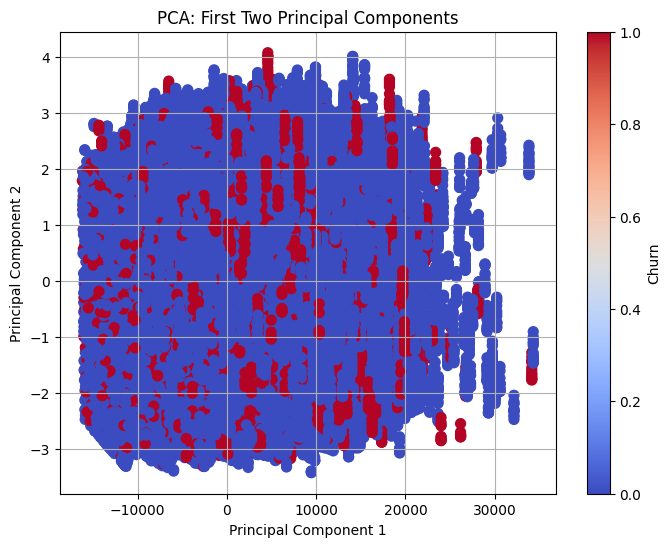

In [100]:
#Applying PCA to the Transformed Dataset

                                                #(A PART)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
# Selecting features for PCA
features_for_pca = data.drop(columns=['Customer ID','Customer Name','Purchase Date'])    # Exclude  Customer ID because its not gonna provide us any benefit.

#Initial PCA: We fit PCA to all selected features.
#we will get how many components are needed to explain a high percentage (e.g., 95%) of the variance.
#Choosing Components: We then select the number of components that explain at least 95% of the total variance.
#PCA Transformation: We apply PCA again, keeping only the selected components, reducing the dataset's dimensionality.

# Selecting features for PCA, excluding categorical and unnecessary columns
features_for_pca = data.drop(columns=['Customer ID', 'Customer Name', 'Purchase Date'])

# Applying PCA
pca = PCA()  
pca.fit(features_for_pca)  # Fitting the PCA model

# Calculating cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Selecting the number of components that explain ~95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because of zero-indexing

# Applying PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(features_for_pca)

# Outputting the number of components selected and shape of the transformed data
#print(f"Number of components selected: {n_components}")
#print("Shape of dataset after PCA:", pca_data.shape)

                                                      #(B part)


# Churn is involved in helping us see if the reduced data (via PCA) shows patterns or differences between customers who churn and those who don't.
                                                      
pca = PCA(n_components=2)  # Reducing to 2 components for visualization
pca_2d = pca.fit_transform(features_for_pca)

# Creating a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=data['Churn'], cmap='coolwarm', s=50)  # Color by 'Churn', change 'Churn' to any other column for a different category

plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Churn')  
plt.grid(True)
plt.show()


#C PART IS ON REPORT



CLV per customer segment:
Churn
0    68455.785422
1    68862.352483
dtype: float64


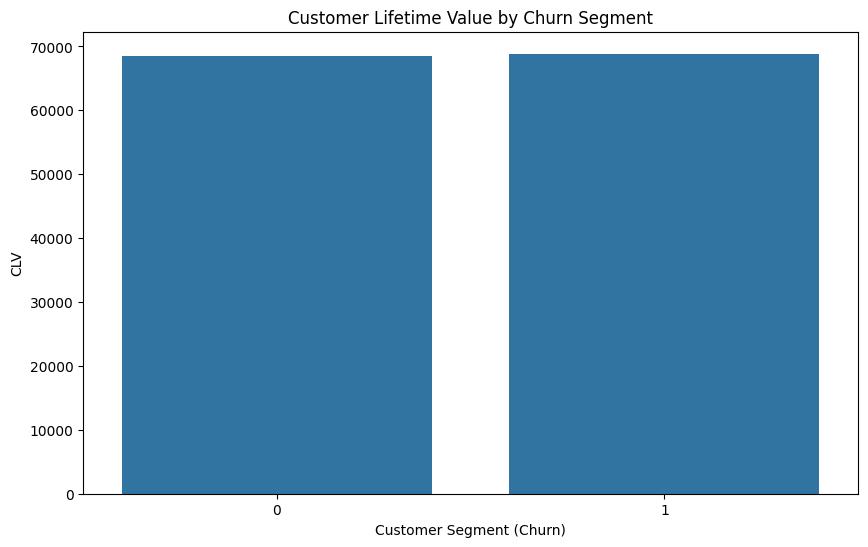

In [101]:
#Customer Lifetime Value (CLV)



# Calculating Average Purchase Value (APV) for each customer segment
avg_purchase_value = data.groupby('Churn')['Total Purchase Value Per Customer'].mean()

# Calculating Purchase Frequency (PF) for each segment
purchase_frequency = data.groupby('Churn')['Number of Purchases'].mean()

# Setting a retention rate (for example, 0.7 or 70%)
retention_rate = 0.7

# Calculating CLV for each customer segment
clv = avg_purchase_value * purchase_frequency * retention_rate

# Adding CLV to the dataset for each customer
data['CLV'] = data['Churn'].map(clv)

# Print the CLV per segment
print("CLV per customer segment:")
print(clv)

# Visualizing the distribution of CLV across segments
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for CLV per segment
plt.figure(figsize=(10, 6))
sns.barplot(x=clv.index, y=clv.values)
plt.title('Customer Lifetime Value by Churn Segment')
plt.xlabel('Customer Segment (Churn)')
plt.ylabel('CLV')
plt.show()


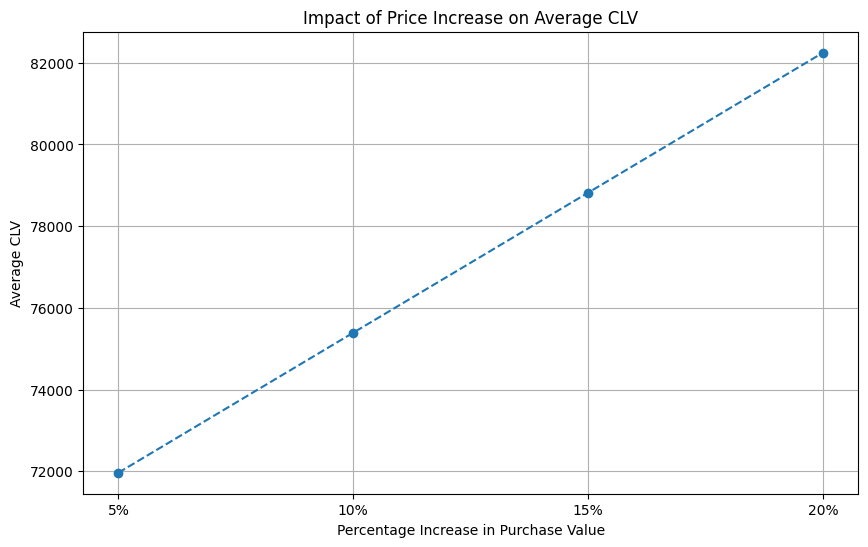

In [103]:
#What-if Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#  range of percentage increases
increases = [0.05, 0.1, 0.15, 0.2]  # 5%, 10%, 15%, 20% increase

# Initializing a list to store results
results = []

for increase in increases:
    # Adjusting the 'Total Purchase Value Per Customer' by the percentage increase
    data['Adjusted Purchase Value'] = data['Total Purchase Value Per Customer'] * (1 + increase)
    
    # Recalculating CLV with the adjusted purchase value
    avg_purchase_value = data.groupby('Churn')['Adjusted Purchase Value'].mean()
    purchase_frequency = data.groupby('Churn')['Number of Purchases'].mean()
    retention_rate = 0.7  # Retention rate
    
    # Calculating CLV for each customer segment
    clv = avg_purchase_value * purchase_frequency * retention_rate
    
    # Adding adjusted CLV to the dataset
    data['Adjusted CLV'] = data['Churn'].map(clv)
    
    # Calculating average CLV for this scenario
    avg_clv = data['Adjusted CLV'].mean()
    
    # Storing results in a list
    results.append({'Price Increase': f"{int(increase*100)}%", 'Average CLV': avg_clv})

# Converting results list to a DataFrame
results_df = pd.DataFrame(results)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Price Increase'], results_df['Average CLV'], marker='o', linestyle='--')
plt.title('Impact of Price Increase on Average CLV')
plt.xlabel('Percentage Increase in Purchase Value')
plt.ylabel('Average CLV')
plt.grid(True)
plt.show()


In [ ]:
#Insights and Narrative

#Are mentioned in detail in the report